In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
from torch import nn, Tensor
import torch.nn.functional as F
import pandas as pd

import vit
import vit1
from helper import *

In [2]:
if torch.cuda.is_available() and USE_CUDA == True:
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
# train = geneDataset("train_adni")
# test = geneDataset("test_adni")

train = geneDataset("train")
test = geneDataset("test")

In [4]:
trainset = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [6]:
net = vit1.VisionTransformer()
# net = Net()
net.to(device)

VisionTransformer(
  (embedding_layer): EmbeddingStem(
    (pos_drop): Dropout(p=0.0, inplace=False)
    (projection): Sequential(
      (0): Conv2d(1, 96, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (qkv): Linear(in_features=96, out_features=288, bias=False)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): Conv1d(96, 192, kernel_size=(1,), stride=(1,))
            (1): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): GELU(approximate=none)
            (3): Dropout(p=0.0, inplace=False)
            (4): Conv

In [7]:
total_params = sum(p.numel() for p in net.parameters())
print(total_params)

624385


In [8]:
# loss_function = torch.nn.BCELoss()
loss_function = torch.nn.L1Loss()

In [9]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

In [10]:
trainloss = []
testloss = []

In [11]:
EPOCHS = 50
count = 0

lowestLoss = 0
lowestNet = 0

In [12]:
from tqdm.notebook import tqdm

for epoch in tqdm(range(EPOCHS)):    
    for data in trainset:
        X, y = data
        X = X.to(device)
        y = y.to(device)

        net.zero_grad()
        output = net(X)
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
        
    count += 1 

    if count % 1 == 0:
        trainloss.append(getTrainAccuracy(net, trainset))

        testLoss = getAccuracy(net, testset)
        testloss.append(testLoss)

        if testLoss > lowestLoss:
            lowestLoss = testLoss
            lowestNet = epoch

            torch.save(net, f"nets/net{epoch}.pt")


print("100% Completed")

  0%|          | 0/50 [00:00<?, ?it/s]

100% Completed


In [13]:
print(lowestNet)
print(lowestLoss)

22
0.868421052631579


In [14]:
# lowestNet = 99

In [15]:
net = torch.load(f"nets/net{lowestNet}.pt")
# net = torch.load(f"anm2.pt")

In [16]:
pos = 0
neg = 0

wrong = 0
right = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data

        X = X.to(device)
        y = y.to(device)
        
        net.eval()

        output = torch.clamp(net(X), min=0.0, max=1.0)

        for i in range(len(output)):
            if y[i][0] == round(float(output[i][0])):
                right += 1
            else:
                wrong += 1

            total += 1

print(right / total)

0.868421052631579


In [17]:
output[i][0]

tensor(0., device='cuda:0')

In [18]:
RES = 1000

In [19]:
falsePos = [0] * RES
truePos = [0] * RES
falseNeg = [0] * RES
trueNeg = [0] * RES

In [20]:
from tqdm.notebook import tqdm

with torch.no_grad():
    for data in tqdm(testset):
        X, y = data
        
        X = X.to(device)
        y = y.to(device)
        
        net.eval()

        output = net(X)
        
        for i in range(RES):
            loss = wrongAns(output, y, 2 * i / (RES - 1) - 0.5)
            truePos[i] += loss[0]
            falsePos[i] += loss[1]
            trueNeg[i] += loss[2]
            falseNeg[i] += loss[3]

  0%|          | 0/19 [00:00<?, ?it/s]

Accuracy: 0.8736842105263158
577


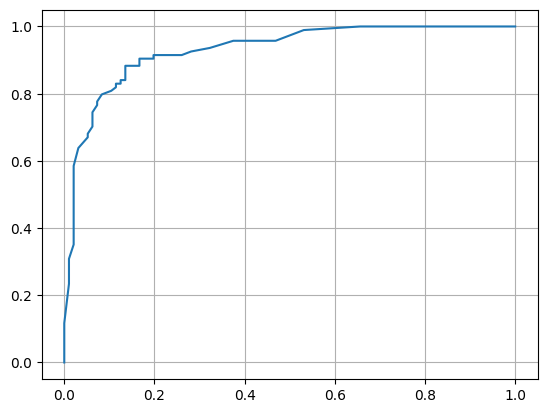

In [21]:
hAcu = 0

falsePosRate = []
truePosRate = []

for i in range(len(truePos)):
    falsePosRate.append(falsePos[i] / (falsePos[i] + trueNeg[i]))
    truePosRate.append(truePos[i] / (truePos[i] + falseNeg[i]))

for i in range(RES):
    if hAcu < truePos[i] + trueNeg[i]:
        hAcu = truePos[i] + trueNeg[i]
        lowestIndex = i

print(f"Accuracy: {(truePos[lowestIndex] + trueNeg[lowestIndex]) / (falsePos[0] + falseNeg[0] + truePos[0] + trueNeg[0])}")
print(lowestIndex)
    
plt.plot(falsePosRate, truePosRate)
plt.grid()

In [22]:
import sklearn.metrics

auc = sklearn.metrics.auc(falsePosRate, truePosRate)

print(auc)

0.9301307624113475


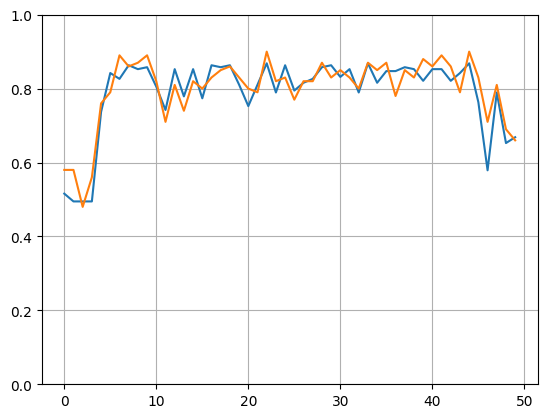

In [23]:
plt.plot(testloss)
plt.plot(trainloss)
plt.ylim([0.0, 1.0])
plt.grid()

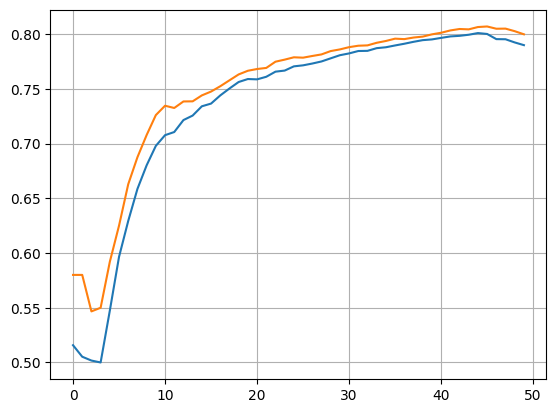

In [24]:
avgTrainLoss = getAvgLoss(trainloss)
avgTestLoss = getAvgLoss(testloss)

plt.plot(avgTestLoss)
plt.plot(avgTrainLoss)
plt.grid()

In [25]:
data = iter(testset)

tensor([0.], device='cuda:0')


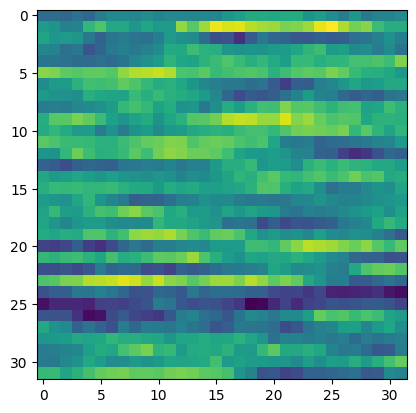

In [33]:
X, y = data.next()

X = X.to(device)
y = y.to(device)
        
output = net(X)

print(y[0])
plt.imshow(X[0].view((32, 32)).cpu())

In [34]:
i = 0

tensor([0.], device='cuda:0')
tensor([-0.0358], device='cuda:0', grad_fn=<SelectBackward0>)


1

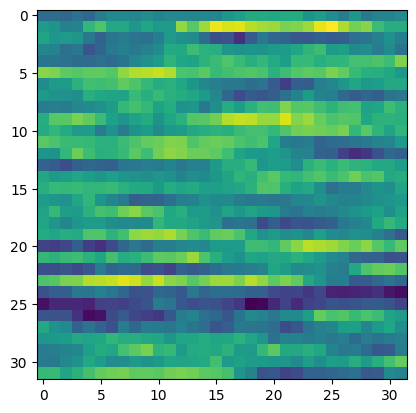

In [35]:
print(y[i])
print(output[i])
plt.imshow(X[i].view((32, 32)).cpu())

i += 1
i %= 100

i

In [29]:
print(y.view(-1))

tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 0.], device='cuda:0')


In [30]:
print(output.view(-1))


tensor([ 1.0070, -0.0419, -0.0258, -0.0288,  1.0122, -0.0302, -0.0352,  1.0095,
        -0.0301,  0.0886], device='cuda:0', grad_fn=<ViewBackward0>)


In [31]:
print(X)

tensor([[[[1.1562, 1.1772, 1.1387,  ..., 1.1696, 1.2009, 1.2217],
          [1.2596, 1.2315, 1.2547,  ..., 1.0393, 1.0533, 0.9914],
          [0.9957, 0.9826, 0.9823,  ..., 1.1136, 1.1574, 1.1057],
          ...,
          [1.1923, 1.1358, 1.1224,  ..., 1.1582, 1.1119, 1.0980],
          [1.1061, 1.1165, 1.0676,  ..., 1.0873, 1.1256, 1.1736],
          [1.1739, 1.1885, 1.1527,  ..., 1.2282, 1.1693, 1.1516]]],


        [[[0.9649, 1.0270, 0.9998,  ..., 0.7750, 0.8261, 0.8036],
          [0.7793, 0.7796, 0.7836,  ..., 0.8072, 0.8354, 0.8076],
          [0.8726, 0.8516, 0.8533,  ..., 0.8886, 0.8751, 0.8332],
          ...,
          [0.8293, 0.8621, 0.8372,  ..., 0.8968, 0.9074, 0.8635],
          [0.8597, 0.8754, 0.8596,  ..., 0.7272, 0.7201, 0.7988],
          [0.8006, 0.8279, 0.8738,  ..., 0.9432, 0.9866, 0.9787]]],


        [[[0.8868, 0.8456, 0.8804,  ..., 0.9027, 0.8928, 0.9460],
          [0.9207, 0.9177, 0.9218,  ..., 0.8574, 0.7909, 0.7994],
          [0.8053, 0.7922, 0.8029,  ..

In [32]:
len(trainset)

8